## Projeto de Classificação com Múltiplos Modelos
Este notebook implementa, treina e avalia modelos de classificação para prever a variável `Response`, a partir de um conjunto de dados processado e clusterizado.

As etapas incluem:
- Pré-processamento personalizado
- Avaliação de múltiplos classificadores
- Comparação de métricas com foco em **average precision**

In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import PercentFormatter

# Pré-processamento e modelagem
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, 
    MinMaxScaler, 
    OneHotEncoder, 
    PowerTransformer,
    StandardScaler,
)

# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression,  SGDClassifier

# estudo árvores
#from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# estudo SVM 

from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

#para avaliar o permutation importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# exportar o modelo
from joblib import dump, load

# Utilitários internos do projeto (src/)
from src.config import (
    ORIGINAL_DATA,  
    TREATED_DATA, 
    CLUSTERED_DATA,
    CLASSIFICATION_MODEL, 
)

from src.graphics import (
    plot_coefficients,
    plot_residuals, 
    plot_residuals_from_estimator, 
    plot_compare_model_metrics,
  )

from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classifier,
    train_and_validate_classification_model,
    organize_cv_results,
)

sns.set_theme(palette='tab10')


#### 📊 Carregamento e análise inicial dos dados

In [2]:
df = pd.read_parquet(CLUSTERED_DATA)

df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Days_Since_Enrolled,Years_Since_Enrolled,Age_Grouped,Mnt_Total,Mnt_Regular,Children,Has_Children,AcceptedCmpTotal,HasAcceptedCmp,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,663,1,46-60,1617,1529,0,0,0,0,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,113,0,46-60,27,21,2,1,0,0,0
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,312,0,46-60,776,734,0,0,0,0,1
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,139,0,18-30,53,48,1,1,0,0,0
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,161,0,31-45,422,407,1,1,0,0,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Education             2212 non-null   object  
 1   Marital_Status        2212 non-null   object  
 2   Income                2212 non-null   float64 
 3   Kidhome               2212 non-null   int64   
 4   Teenhome              2212 non-null   int64   
 5   Recency               2212 non-null   int64   
 6   MntWines              2212 non-null   int64   
 7   MntFruits             2212 non-null   int64   
 8   MntMeatProducts       2212 non-null   int64   
 9   MntFishProducts       2212 non-null   int64   
 10  MntSweetProducts      2212 non-null   int64   
 11  MntGoldProds          2212 non-null   int64   
 12  NumDealsPurchases     2212 non-null   int64   
 13  NumWebPurchases       2212 non-null   int64   
 14  NumCatalogPurchases   2212 non-null   int64   
 15  NumS

In [4]:
# Agrupamento das colunas de acordo com o pré-processamebto necessário
numerical_features = list(df.select_dtypes("number").columns)
len(numerical_features)

32

#### ⚙️ Separação da variável target e preditoras

In [5]:
X= df.drop("Response", axis=1)
y= df["Response"]

#### Fluxo da Análise:

##### 1. Pré-processamento dos Dados:
Transformação de Variáveis:

* Variáveis categóricas: serão codificadas via OneHotEncoder

* Variáveis Age e Income: estão próximas da distribuição normal. O StandardScaler é uma boa opção nesse caso.

* Variáveis Days Since Enrolled e Recency: possuem distribuição uniforme. O MinMaxScaler irá colocar dentro da escala (padrão 0 e 1)

* Variáveis Num e Mnt: possuem a distribuição enviesada, usarei o Power Transformer para deixar a distribuição mais próxima do normal


In [6]:
#colunas categóricas
one_hot_cols=[
    'Education',
    'Marital_Status',
    'Age_Grouped',
    'Kidhome',
    'Teenhome',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Complain',
    'Years_Since_Enrolled',
    'Has_Children',
    'Children',
    'AcceptedCmpTotal',
    'HasAcceptedCmp',
    'Cluster'
]



#standard
standard_cols= [
    'Income',
    'Age'
]

#power transformer
power_cols= X.columns[
X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()

#min_max
minmax_cols = [
    col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols
]

#### 🎯 Codificação da variável alvo

In [7]:
#codificação da coluna target
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())
y

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

#### 📈 Configuração da validação cruzada e peso para classe minoritária

Quando trabalhamos com problemas de classificação (como este, em que o objetivo é prever a variável Response), é comum que a distribuição das classes seja desbalanceada. Se usarmos uma validação cruzada comum (como o KFold padrão), pode acontecer de alguns folds ficarem com poucas ou nenhuma instância de uma das classes.

✅ A validação cruzada estratificada garante que cada fold mantenha aproximadamente a mesma proporção de classes da variável-alvo (no caso, Response) que o conjunto original. Isso é especialmente importante quando o dataset é desbalanceado, pois evita que o modelo aprenda com dados "viciados".

✅ O parâmetro scale_pos_weight é uma forma de compensar esse desbalanceamento nos modelos XGBoost e LightGBM, informando que erros na classe minoritária devem ser penalizados mais.

    • Melhora a sensibilidade (recall) da classe minoritária.
    • Reduz o viés do modelo em prever sempre a classe majoritária.

In [8]:
# Validação cruzada estratificada com 5 divisões (folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [9]:
# Peso da classe positiva para modelos de árvores (base desbalanceada)
scale_pos_weight = np.bincount(y)[0]/ np.bincount(y)[1]
scale_pos_weight 

5.642642642642643

#### Pipelines de pré-processamento

##### 🧱 Pipeline do Projeto
Um pipeline no scikit-learn é uma estrutura que organiza o fluxo completo de processamento de dados e modelagem em uma sequência lógica e reutilizável.

Neste projeto, cada modelo de classificação foi encapsulado dentro de um pipeline com os seguintes passos:

    - Pré-processamento (preprocessor)
        *Transforma os dados de entrada de forma adequada para o modelo.
  

    - Seleção de características (SelectKBest) (opcional)
      * Algumas combinações de modelo + pré-processamento utilizam seleção de variáveis com base em teste estatístico (f_classif), para reduzir dimensionalidade e melhorar desempenho.

  
    - Modelo de classificação
      * O algoritmo de machine learning propriamente dito (como LogisticRegression, KNeighborsClassifier, XGBClassifier, entre outros).


In [10]:
# Pipeline padrão para maioria dos modelos
preprocessing = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop='first'), one_hot_cols),  
        ("PowerTransformer",PowerTransformer(), power_cols),     
        ("standard", StandardScaler(), standard_cols), 
        ("minmax",MinMaxScaler(), minmax_cols), 
    ]
)
# Para modelos baseados em árvore (não precisam de escalonamento)
tree_preprocessing = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), one_hot_cols),
    ]
)

#### Definição dos modelos
##### Modelos incluídos:

- DummyClassifier (baseline aleatória)
  
      * Serve como um ponto de referência mínimo de desempenho
- Regressão Logística
  
      * É simples, eficiente e rápido, especialmente em datasets com número razoável de features.
      * Interpretação direta dos coeficientes ajuda na explicação do modelo.
      * Funciona bem quando a relação entre as variáveis é aproximadamente linear.
- SGDClassifier
  
      * Treina modelos lineares (como regressão logística ou SVM) usando gradiente descendente estocástico.
- K-Nearest Neighbors
  
      * Classifica um exemplo com base na votação dos K vizinhos mais próximos.
- Suporte a Vetores (SVM)
  
      * Encontra um hiperplano ótimo que separa as classes, com margem máxima.
- XGBoost
  
      * Constrói árvores de decisão de forma sequencial, corrigindo erros anteriores com pesos.
      * Excelente desempenho em dados desbalanceados, especialmente com o parâmetro scale_pos_weight.
- LightGBM
  
      * Semelhante ao XGBoost, mas mais rápido, usando histogramas e crescimento leaf-wise.


In [11]:
classifiers = {
    "DummyClassifier": {
        "preprocessor": tree_preprocessing ,
        "classifier": DummyClassifier(strategy="stratified")
    },
    
     "LogisticRegression": {
        "preprocessor": preprocessing,
        "classifier": LogisticRegression(
            class_weight= 'balanced'
        ),
         "feature_selector": SelectKBest()
    },
     
    "SGDClassifier": {
        "preprocessor": preprocessing,
        "classifier": SGDClassifier(),
        "feature_selector": SelectKBest()
    },

    #knn

    "KNNClassifier": {
        "preprocessor": preprocessing,
        "classifier": KNeighborsClassifier(
            n_neighbors=5),
        "feature_selector": SelectKBest()
    },

    #svm
     "SVC": {
         "preprocessor": preprocessing,
         "classifier": SVC(),
         "feature_selector": SelectKBest()
    },
  
    # modelos baseado em árvores de decisão

 
     "XGBClassifier": {
        "preprocessor": tree_preprocessing ,
        "classifier": XGBClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        ),
         "feature_selector": SelectKBest()
     },

    "LGBMclassifier": {
        "preprocessor": tree_preprocessing ,
        "classifier": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight,
            verbose=-1
        ),
         "feature_selector": SelectKBest()
    }, 
    
   
}

In [12]:
# ⚠️ Tratamento de Warnings no Código
#Durante a execução dos modelos e transformações no pipeline, diversos avisos (warnings) foram gerados — muitos deles relacionados a:
import warnings
warnings.filterwarnings('ignore')

⚠️ Tratamento de Warnings no Código:
Durante a execução dos modelos e transformações no pipeline, diversos avisos (warnings) foram gerados.
Retirei os warnings para manter a saída do notebook limpa, legível e focada nos resultados principais, uma vez que:
* os avisos não afetavam a execução ou os resultados dos modelos.
* Todos os warnings relevantes foram previamente analisados para garantir que nenhum erro crítico ou comportamento inesperado fosse ignorado.
* Essa abordagem ajuda a evitar poluição visual nos logs, especialmente durante validação cruzada ou ajustes de modelos, onde muitos loops e mensagens são geradas.


#### 📉 Treinamento e avaliação dos modelos

In [13]:
results = {
    model_name: train_and_validate_classification_model(X, y, kf, **classifier)
    for model_name, classifier in classifiers.items()
}

#consolidação dos resultados
df_results = organize_cv_results(results)

df_results

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_f2_score,time_seconds
0,DummyClassifier,0.050207,0.069118,0.758465,0.532669,0.207407,0.205882,0.208955,0.492398,0.149504,0.208333,0.119325
1,DummyClassifier,0.032741,0.066128,0.740406,0.460702,0.065041,0.071429,0.059701,0.501489,0.15163,0.061728,0.09887
2,DummyClassifier,0.035734,0.067773,0.721719,0.480498,0.12766,0.121622,0.134328,0.464776,0.14615,0.131579,0.103507
3,DummyClassifier,0.032,0.065873,0.762443,0.504352,0.146341,0.157895,0.136364,0.562701,0.177769,0.140187,0.097873
4,DummyClassifier,0.037996,0.065855,0.769231,0.520833,0.177419,0.189655,0.166667,0.505279,0.150747,0.170807,0.103851
5,LogisticRegression,0.254392,0.074857,0.776524,0.69663,0.440678,0.354545,0.58209,0.764449,0.412025,0.515873,0.32925
6,LogisticRegression,0.237475,0.095597,0.774266,0.6953,0.438202,0.351351,0.58209,0.748948,0.493228,0.514512,0.333072
7,LogisticRegression,0.222133,0.10068,0.766968,0.746209,0.482412,0.363636,0.716418,0.795363,0.464604,0.6,0.322814
8,LogisticRegression,0.248965,0.095173,0.778281,0.744761,0.484211,0.370968,0.69697,0.845785,0.569003,0.592784,0.344139
9,LogisticRegression,0.259279,0.105696,0.846154,0.790901,0.580247,0.489583,0.712121,0.840587,0.572269,0.652778,0.364975


#### 📈 12. Comparação gráfica das métricas

In [14]:
#vou usar a métrica average_precision por combinar as métricas precisão e recall dando peso a ambas.
df_results.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_f2_score,time_seconds
model,,,,,,,,,,,
DummyClassifier,0.037736,0.06695,0.750453,0.499811,0.144774,0.149296,0.141203,0.505329,0.15516,0.142527,0.104685
KNNClassifier,0.179321,0.169846,0.862121,0.63849,0.409919,0.581843,0.318498,0.730616,0.38433,0.349514,0.349166
XGBClassifier,0.398858,0.082172,0.753181,0.710287,0.444717,0.340455,0.648892,0.748457,0.434831,0.547195,0.48103
SGDClassifier,0.150806,0.082837,0.849908,0.60998,0.330432,0.652778,0.266848,0.738406,0.447241,0.283928,0.233642
LGBMclassifier,0.556774,0.074509,0.750921,0.717632,0.450709,0.341435,0.669968,0.765862,0.452338,0.559901,0.631283
SVC,0.323522,0.225624,0.866182,0.581426,0.277087,0.78191,0.174039,0.70265,0.457098,0.204124,0.549146
LogisticRegression,0.244449,0.094401,0.788439,0.73476,0.48515,0.386017,0.657938,0.799026,0.502226,0.575189,0.33885


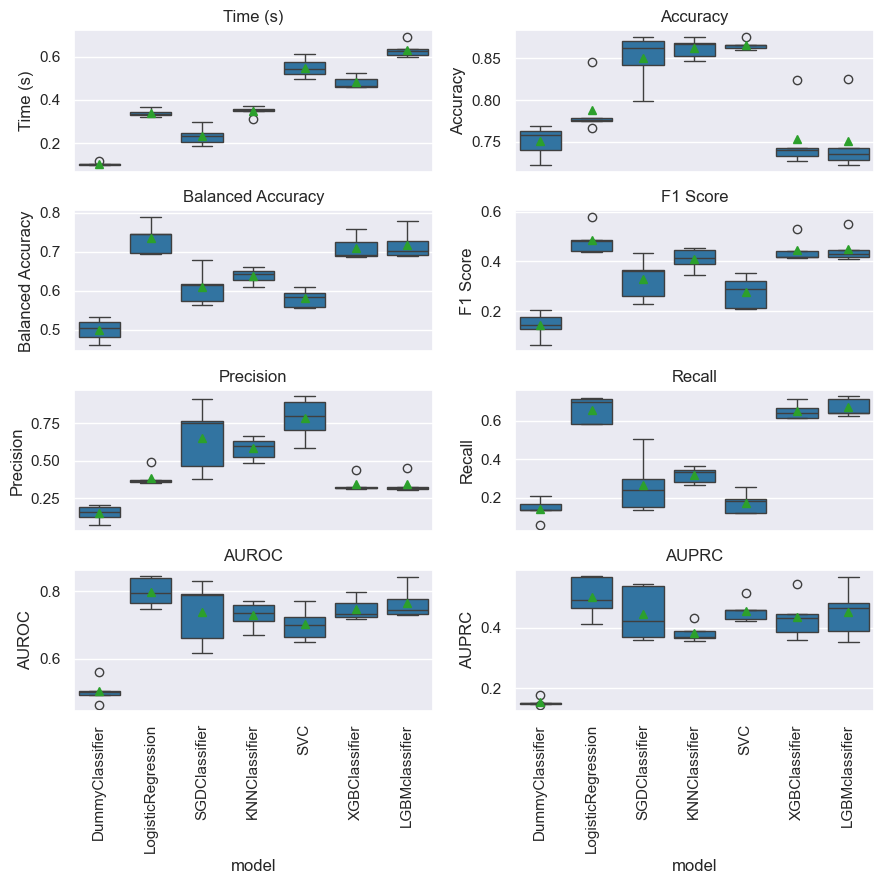

In [15]:
plot_compare_model_metrics(df_results)

##📝 Considerações Finais

#### ✅ Conclusões

- Modelos lineares como Regressão Logística tiveram ótimo desempenho, mesmo em comparação com modelos de árvore.
- O uso de `average_precision` como métrica principal foi essencial para melhor interpretação do desempenho em uma base desbalanceada.

#### 🔜 Próximos Passos

- Aplicar busca em grade (`GridSearchCV`) para otimização de hiperparâmetros.
